# One-Shot Learning Training and Prediction Results

reference:
https://towardsdatascience.com/building-a-one-shot-learning-network-with-pytorch-d1c3a5fafa4a
https://becominghuman.ai/siamese-networks-algorithm-applications-and-pytorch-implementation-4ffa3304c18

[3] "We are interested in the problem of learning and recognition of <u>categories</u> (as opposed to individual objects)" 
[3] "Another aspect that we wish to emphasize is the ability to learn with minimal supervision."

[3] Li Fei-Fei, R. Fergus and P. Perona, "One-shot learning of object categories," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 28, no. 4, pp. 594-611, April 2006, doi: 10.1109/TPAMI.2006.79.

In [1]:
from __future__ import print_function, division

import sys
import platform
import time
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

# this is necessary to use the common functions
# assumes directory structure was maintained
sys.path.insert(0, '../common/')
# from common.torch_utils import train_model,get_device
# from torch_utils import (train_model, 
#                          mnist_dataloader, 
#                          dataset_preview)
# from torch_utils import *
from oneshot import *


# print some versions
print(f'Python Version:      {platform.python_version()}')
print(f'PyTorch Version:     {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')
print(f'CUDA Version:        {torch.version.cuda}')

# get device (defaults to GPU if available)
device = get_device()

Python Version:      3.7.8
PyTorch Version:     1.7.1+cu101
Torchvision Version: 0.8.2+cu101
CUDA Version:        10.1

***********************************
GPU Available:  True
Current Device: cuda:0 (Tesla V100-SXM2-16GB)
***********************************



To keep as consistent as possible with the reference article, let's observe the following excerpt:

> Batch Size: Since we are learning how similar are two images, the batch size needs to be pretty big in order for the model to be generalisable especially for a dataset like this with many different categories. Therefore we used a batch size of 128.   
>
> Learning Rate: We tested with several learning rates from 0.001 to 0.0005, and selected a 0.0006 which provided the best loss decreasing rate.   
>
> Optimizer and Loss: We adopted the traditional Adam optimizer for this network with the binary cross entropy (BCE) loss with logits.

Another excerpt from the article that will drive design decisions:
... could be due to the fact that the kernel size of the convolutional layers is fairly small (3x3), which gives a small receptive field. For a problem of computing similarity between two images, it may perhaps be beneficial to look at a “bigger picture” of the two images instead of focusing on small details, and hence a larger receptive field proposed in the original network worked better.

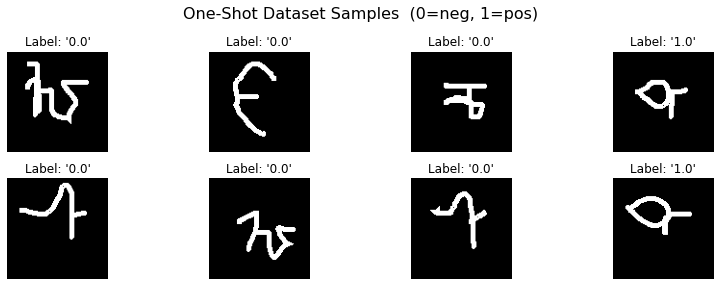

In [10]:
BATCH_SIZE = 32
SET_SIZE = 1000

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
}

data_dir='../../data'
train_categories = ['Greek','Tagalog','Latin','']
# use helper to create the dataloaders
train_set = OmniglotDataset(root=data_dir, set_size=SET_SIZE, 
                            categories=train_categories,
                            train=True, download=True, 
                            transform=data_transforms['train'])

test_categories = ['Mongolian']
val_set = OmniglotDataset(root=data_dir, set_size=SET_SIZE, 
                            categories=test_categories,
                            train=False, download=True, 
                            transform=data_transforms['val'])


# make the dataloader
dataloaders = {}
image_datasets = {'train':train_set, 'val':val_set}
for x in image_datasets:
    dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], 
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True, num_workers=4)
# collect the dataset size and class names
dataset_sizes = {x: len(image_datasets[x]) for x in image_datasets}
class_names = image_datasets['train'].classes

# # preview the dataset
oneshot_dataset_preview(dataloaders['val'])

In [13]:
# Use Torchvision Resnet18 for base model since our 
# dataset is small and only has 10 classes this should
# be well suited. DO NOT PRETRAIN FOR BASE MODEL.
model = VGGSiameseNet()

# 
output_dir='output'
num_epochs = 50
#     == We must changet the last fully connected layer to match 10 classes
# keep features unchanged

# move model to the GPU
cudnn.benchmark = True

# use helper function to train the model (outputs model and Pandas DF)
print(f'\nTraining One-shot model')
model, results_df,_ = train_oneshot(device, model, dataloaders, 
                                       dataset_sizes, output_dir=output_dir, 
                                       num_epochs=num_epochs)

# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'oneshot_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
results_df.to_csv(os.path.join(output_dir,results_file),
                  columns=results_df.columns)
print(f'> Saved results to \'{results_file}\'.')


Training One-shot model

Epoch 0/49
----------
Train Loss: 0.6707 Train Acc: 0.7812
Val Loss: 0.6704 Val Acc: 0.8438
---------|9
Epoch 10/49
----------
Train Loss: 0.5609 Train Acc: 0.7812
Val Loss: 0.6315 Val Acc: 0.5312
---------|19
Epoch 20/49
----------
Train Loss: 0.5174 Train Acc: 0.625
Val Loss: 0.6036 Val Acc: 0.6562
---------|29
Epoch 30/49
----------
Train Loss: 0.5102 Train Acc: 0.7812
Val Loss: 0.577 Val Acc: 0.6875
---------|39
Epoch 40/49
----------
Train Loss: 0.4368 Train Acc: 0.9062
Val Loss: 0.615 Val Acc: 0.7812
--------|48
Epoch 49/49
----------
Train Loss: 0.4283 Train Acc: 0.8125
Val Loss: 0.5987 Val Acc: 0.75
Finished Training
Training complete in 2.0m 11.687387228012085s
Best val Acc: 0.9062
> Saved results to 'oneshot_results_2020-12-15T040653.csv'.


Index(['device', 'epoch', 'average_training_loss', 'average_validation_loss',
       'training_acc', 'validaton_acc', 'training_time', 'validation_time'],
      dtype='object')


<AxesSubplot:xlabel='epoch'>

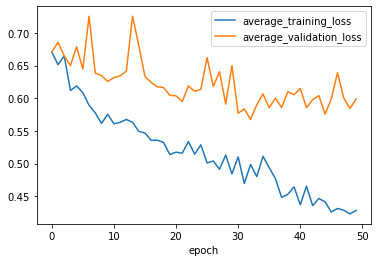

In [14]:
print(results_df.columns)
results_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'], style='-')

https://towardsdatascience.com/building-a-one-shot-learning-network-with-pytorch-d1c3a5fafa4a#bc   

In a Siamese network, a single number is output from the model. This number represents how similar the two inputs are, where a larger number implies that the two images are more similar.

In other words, if the current iteration is an odd number, we retrieve a pair of images from the same character, and vice versa. This ensures that our training dataset is balanced for both types of outputs.

## Validation
Refer to this to get accuracy:   
https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d   

__Possible Hyperparams:__   
optimizer = Adam(lr = 0.00006)   
model.compile(loss="binary_crossentropy",optimizer=optimizer)